In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

CREATING THE DATAFRAME OF PAIRS OF DIRECTORS AND ACTORS

In [2]:
movie_industry = pd.read_csv("../data/movie_industry.csv", encoding = "ISO-8859-1" )
movie_industry.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


In [3]:
class Graph:
    """ Wrapper class Graph to create a bipartite graph
    Takes in the following paramaters
    directors_to_actors_relation : Dataframe with the data for directors and actors
    weight func : function which defined the weight of an edge. Takes the dateframe to calcuate weights from and
    the nodes values to calculate for
    weight_func_args : column names used to calculate the weights
    director_column : Column name for director
    actor_column : Column name for actor, 
    bipartite : default true
    """
    def __init__(self, 
                 directors_to_actors_relation, 
                 weight_func, 
                 weight_func_args, 
                 director_column="director", 
                 actor_column="star", 
                 bipartite=True):
        self.G = nx.Graph()
        
        directors = set(directors_to_actors_relation[director_column].values)
        actors = set(directors_to_actors_relation[actor_column].values)
    
        #store the director node as a tuple with director name and boolean True to indicate director
        for director in directors:
            self.G.add_node((director, True))
            
        #store the actor node as a tuple with actor name and boolean False to indicate actor
        for actor in actors:
            self.G.add_node((actor, False))

        #add weights to all edges
        for director in directors:
            rows = directors_to_actors_relation[directors_to_actors_relation[director_column] == director]
            for index in rows.index.values:
                self.G.add_edge((director, True), 
                                (rows.loc[index, actor_column], False), 
                                weight=weight_func(*[rows.loc[index, i] for i in weight_func_args], directors_to_actors_relation))             

In [4]:
#calcualtes edge weight as the number of collaborations
#takes in director name, star name and data to calculate weight from
def example_weight_func(director, star, df):
    return len(df.loc[((df["director"] == director) & (df["star"] == star))])

In [5]:
storage = Graph(movie_industry, example_weight_func, ["director", "star"])

In [6]:
directors = list(set(movie_industry["director"].values))
actors = list(set(movie_industry["star"].values))

In [7]:
collabs = []
for director in directors:
    for actor in actors:
        if storage.G.get_edge_data((director, True), (actor, False)):
            collabs.append(storage.G.get_edge_data((director, True), (actor, False))["weight"])
        else:
            collabs.append(0)

In [8]:
res =  [director for director in directors for i in range(len(actors))] 
df = pd.DataFrame({"director": res, 
                   "actor": actors*len(directors),
                  "collabs": collabs})
df

,director,actor,collabs
0,Joe Pytka,Diane Lane,0
1,Joe Pytka,Vincent Spano,0
2,Joe Pytka,Leonardo DiCaprio,0
3,Joe Pytka,Richard Farnsworth,0
4,Joe Pytka,Juan Diego,0
...,...,...,...
6908531,Max Mayer,John Rhys-Davies,0
6908532,Max Mayer,Delphine Zentout,0
6908533,Max Mayer,Charlotte Véry,0
6908534,Max Mayer,Ari Graynor,0


In [10]:
df

,director,actor,collabs
0,Joe Pytka,Diane Lane,0
1,Joe Pytka,Vincent Spano,0
2,Joe Pytka,Leonardo DiCaprio,0
3,Joe Pytka,Richard Farnsworth,0
4,Joe Pytka,Juan Diego,0
...,...,...,...
6908531,Max Mayer,John Rhys-Davies,0
6908532,Max Mayer,Delphine Zentout,0
6908533,Max Mayer,Charlotte Véry,0
6908534,Max Mayer,Ari Graynor,0


ADDING AND TESTING COVARIATES

In [9]:
actor_total_gross = {}
actor_mean_gross = {}
for actor in actors:
    temp = movie_industry[movie_industry.star ==  actor]
    sum_gross = sum(temp.gross.values)
    mean_gross = np.mean(temp.gross.values)
    actor_total_gross[actor] = sum_gross
    actor_mean_gross[actor] = mean_gross

In [20]:
director_total_gross = {}
director_mean_gross = {}
for director in directors:
    temp = movie_industry[movie_industry.director ==  director]
    sum_gross = sum(temp.gross.values)
    mean_gross = np.mean(temp.gross.values)
    director_total_gross[director] = sum_gross
    director_mean_gross[director] = mean_gross

In [21]:
df["director_total_gross"] = df.director.map(director_total_gross)
df["director_mean_gross"] = df.director.map(director_mean_gross)
df["actor_total_gross"] = df.actor.map(actor_total_gross)
df["actor_mean_gross"] = df.actor.map(actor_mean_gross)

In [22]:
df["collab indicator"] = (df.collabs > 0)*1

In [23]:
df["total_gross_diff"] = abs(df.director_total_gross - df.actor_total_gross)
df["mean_gross_diff"] = abs(df.director_mean_gross - df.actor_mean_gross)

In [199]:
df

,director,actor,collabs,director_total_gross,director_mean_gross,actor_total_gross,actor_mean_gross,collab indicator,total_gross_diff,mean_gross_diff,ratings_tvd,genre_tvd
0,Joe Pytka,Diane Lane,0,95436819.0,47718409.5,2.459255e+08,2.732506e+07,0,1.504887e+08,2.039335e+07,0.333333,0.555556
1,Joe Pytka,Vincent Spano,0,95436819.0,47718409.5,1.264910e+06,1.264910e+06,0,9.417191e+07,4.645350e+07,1.000000,1.000000
2,Joe Pytka,Leonardo DiCaprio,0,95436819.0,47718409.5,2.304909e+09,1.213110e+08,0,2.209472e+09,7.359259e+07,0.631579,1.000000
3,Joe Pytka,Richard Farnsworth,0,95436819.0,47718409.5,6.203044e+06,6.203044e+06,0,8.923378e+07,4.151537e+07,1.000000,1.000000
4,Joe Pytka,Juan Diego,0,95436819.0,47718409.5,7.891270e+05,7.891270e+05,0,9.464769e+07,4.692928e+07,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
6908531,Max Mayer,John Rhys-Davies,0,2277396.0,2277396.0,1.814100e+05,1.814100e+05,0,2.095986e+06,2.095986e+06,1.000000,1.000000
6908532,Max Mayer,Delphine Zentout,0,2277396.0,2277396.0,4.101090e+05,4.101090e+05,0,1.867287e+06,1.867287e+06,1.000000,1.000000
6908533,Max Mayer,Charlotte Véry,0,2277396.0,2277396.0,2.136870e+05,2.136870e+05,0,2.063709e+06,2.063709e+06,1.000000,0.000000
6908534,Max Mayer,Ari Graynor,0,2277396.0,2277396.0,1.243961e+06,1.243961e+06,0,1.033435e+06,1.033435e+06,1.000000,1.000000


In [39]:
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp

Mean gross Difference

In [40]:
bins = np.linspace(min(df.mean_gross_diff.values), max(df.mean_gross_diff.values), 50)

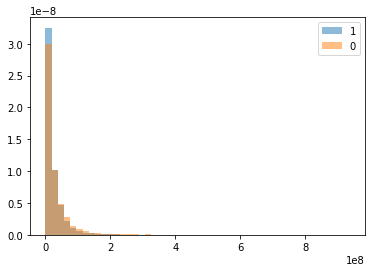

In [36]:
plt.hist(df[df["collab indicator"] == 1].mean_gross_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df[df["collab indicator"] == 0].mean_gross_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

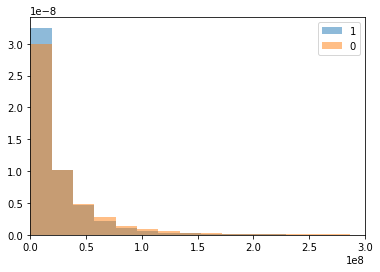

In [38]:
plt.hist(df[df["collab indicator"] == 1].mean_gross_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df[df["collab indicator"] == 0].mean_gross_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.xlim(0, 300000000)
plt.legend()

In [26]:
np.var(df[df["collab indicator"] == 1].mean_gross_diff.values)

1050745802394769.6

In [27]:
np.var(df[df["collab indicator"] == 0].mean_gross_diff.values)

2096009318756954.5

In [30]:
ttest_ind(df[df["collab indicator"] == 1].mean_gross_diff.values, 
                      df[df["collab indicator"] == 0].mean_gross_diff.values, 
                      equal_var=False)

Ttest_indResult(statistic=-16.015154834135338, pvalue=1.2835183502642684e-56)

In [34]:
ks_2samp(df[df["collab indicator"] == 1].mean_gross_diff.values, 
                      df[df["collab indicator"] == 0].mean_gross_diff.values)

Ks_2sampResult(statistic=0.09593936008176188, pvalue=8.546734041695773e-51)

Total gross differnece

In [41]:
bins = np.linspace(min(df.total_gross_diff.values), max(df.total_gross_diff.values), 50)

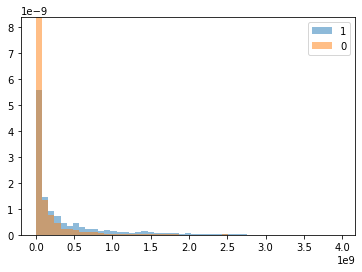

In [42]:
plt.hist(df[df["collab indicator"] == 1].total_gross_diff.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df[df["collab indicator"] == 0].total_gross_diff.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [49]:
np.var(df[df["collab indicator"] == 1].total_gross_diff.values)

2.886759169959315e+17

In [50]:
np.var(df[df["collab indicator"] == 0].total_gross_diff.values)

1.002811524720565e+17

In [51]:
ttest_ind(df[df["collab indicator"] == 1].total_gross_diff.values, 
                      df[df["collab indicator"] == 0].total_gross_diff.values, 
                      equal_var=False)

Ttest_indResult(statistic=29.307689197428616, pvalue=3.9445543251715487e-177)

In [52]:
ks_2samp(df[df["collab indicator"] == 1].total_gross_diff.values, 
                      df[df["collab indicator"] == 0].total_gross_diff.values)

Ks_2sampResult(statistic=0.2285422120770127, pvalue=2.972960640425862e-286)

RATINGS

In [54]:
movie_industry

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6815,0.0,Fox Searchlight Pictures,UK,Mandie Fletcher,Comedy,4750497.0,Absolutely Fabulous: The Movie,R,2016-07-22,91,5.4,Jennifer Saunders,9161,Jennifer Saunders,2016
6816,0.0,Siempre Viva Productions,USA,Paul Duddridge,Drama,28368.0,Mothers and Daughters,PG-13,2016-05-06,90,4.9,Selma Blair,1959,Paige Cameron,2016
6817,3500000.0,Warner Bros. Animation,USA,Sam Liu,Animation,3775000.0,Batman: The Killing Joke,R,2016-07-25,76,6.5,Kevin Conroy,36333,Brian Azzarello,2016
6818,0.0,Borderline Presents,USA,Nicolas Pesce,Drama,25981.0,The Eyes of My Mother,R,2016-12-02,76,6.2,Kika Magalhães,6947,Nicolas Pesce,2016


In [74]:
ratings = np.unique(movie_industry.rating.values)
ratings

array(['B', 'B15', 'G', 'NC-17', 'NOT RATED', 'Not specified', 'PG',
       'PG-13', 'R', 'TV-14', 'TV-MA', 'TV-PG', 'UNRATED'], dtype=object)

In [102]:
dir_ratings_prop = {}
for director in directors:
    temp = movie_industry[movie_industry.director == director].groupby(["rating"])["director"].count()
    prop = []
    total = sum(temp.values)
    for category in ratings:
        if category in temp.index:
            prop.append(temp[category]/total)
        else:
            prop.append(0)
    dir_ratings_prop[director] = np.array(prop)

In [103]:
act_ratings_prop = {}
for actor in actors:
    temp = movie_industry[movie_industry.star == actor].groupby(["rating"])["star"].count()
    prop = []
    total = sum(temp.values)
    for category in ratings:
        if category in temp.index:
            prop.append(temp[category]/total)
        else:
            prop.append(0)
    act_ratings_prop[actor] = np.array(prop)

In [112]:
%%time
ratings_tvd = []
for i in df.index:
    director = df.director[i]
    actor = df.actor[i]
    tvd = sum(abs(dir_ratings_prop[director] - act_ratings_prop[actor]))/2
    ratings_tvd.append(tvd)

CPU times: user 6min 15s, sys: 2.78 s, total: 6min 18s
Wall time: 6min 46s


In [113]:
df["ratings_tvd"] = ratings_tvd

In [118]:
bins = np.linspace(min(ratings_tvd), max(ratings_tvd), 20)

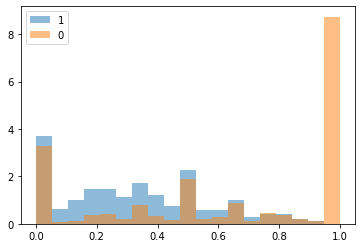

In [119]:
plt.hist(df[df["collab indicator"] == 1].ratings_tvd.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df[df["collab indicator"] == 0].ratings_tvd.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [120]:
np.var(df[df["collab indicator"] == 1].ratings_tvd.values)

0.05878517450152846

In [121]:
np.var(df[df["collab indicator"] == 0].ratings_tvd.values)

0.15064050496672002

In [122]:
ttest_ind(df[df["collab indicator"] == 1].ratings_tvd.values, 
                      df[df["collab indicator"] == 0].ratings_tvd.values, 
                      equal_var=False)

Ttest_indResult(statistic=-105.2442161747297, pvalue=0.0)

In [123]:
ks_2samp(df[df["collab indicator"] == 1].ratings_tvd.values, 
                      df[df["collab indicator"] == 0].ratings_tvd.values)

Ks_2sampResult(statistic=0.45962116591304547, pvalue=0.0)

Genre

In [124]:
genre = np.unique(movie_industry.genre.values)
genre

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Horror', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], dtype=object)

In [132]:
dir_genre_prop = {}
for director in directors:
    temp = movie_industry[movie_industry.director == director].groupby(["genre"])["director"].count()
    prop = []
    total = sum(temp.values)
    for category in genre:
        if category in temp.index:
            prop.append(temp[category]/total)
        else:
            prop.append(0)
    dir_genre_prop[director] = np.array(prop)

In [138]:
act_genre_prop = {}
for actor in actors:
    temp = movie_industry[movie_industry.star == actor].groupby(["genre"])["star"].count()
    prop = []
    total = sum(temp.values)
    for category in genre:
        if category in temp.index:
            prop.append(temp[category]/total)
        else:
            prop.append(0)
    act_genre_prop[actor] = np.array(prop)

In [141]:
%%time
genre_tvd = []
for i in df.index:
    director = df.director[i]
    actor = df.actor[i]
    tvd = sum(abs(dir_genre_prop[director] - act_genre_prop[actor]))/2
    genre_tvd.append(tvd)

CPU times: user 6min 14s, sys: 2.05 s, total: 6min 16s
Wall time: 6min 40s


In [142]:
df["genre_tvd"] = genre_tvd

In [144]:
bins = np.linspace(min(genre_tvd), max(genre_tvd), 20)
bins

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

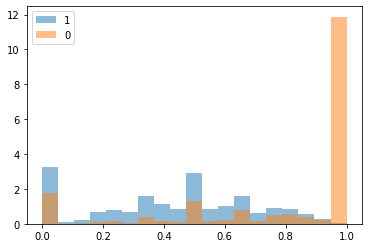

In [145]:
plt.hist(df[df["collab indicator"] == 1].genre_tvd.values, density = True, bins = bins, label = "1", alpha = 0.5)
plt.hist(df[df["collab indicator"] == 0].genre_tvd.values, density = True, bins = bins, label = "0", alpha = 0.5)
plt.legend()

In [146]:
np.var(df[df["collab indicator"] == 1].genre_tvd.values)

0.07092228627223895

In [147]:
np.var(df[df["collab indicator"] == 0].genre_tvd.values)

0.10616452402623691

In [148]:
ttest_ind(df[df["collab indicator"] == 1].genre_tvd.values, 
                      df[df["collab indicator"] == 0].genre_tvd.values, 
                      equal_var=False)

Ttest_indResult(statistic=-108.7801938670433, pvalue=0.0)

In [149]:
ks_2samp(df[df["collab indicator"] == 1].genre_tvd.values, 
                      df[df["collab indicator"] == 0].genre_tvd.values)

Ks_2sampResult(statistic=0.6234951602598001, pvalue=0.0)

Show past collaboration makes another collboration more likely

In [162]:
movie_industry

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6815,0.0,Fox Searchlight Pictures,UK,Mandie Fletcher,Comedy,4750497.0,Absolutely Fabulous: The Movie,R,2016-07-22,91,5.4,Jennifer Saunders,9161,Jennifer Saunders,2016
6816,0.0,Siempre Viva Productions,USA,Paul Duddridge,Drama,28368.0,Mothers and Daughters,PG-13,2016-05-06,90,4.9,Selma Blair,1959,Paige Cameron,2016
6817,3500000.0,Warner Bros. Animation,USA,Sam Liu,Animation,3775000.0,Batman: The Killing Joke,R,2016-07-25,76,6.5,Kevin Conroy,36333,Brian Azzarello,2016
6818,0.0,Borderline Presents,USA,Nicolas Pesce,Drama,25981.0,The Eyes of My Mother,R,2016-12-02,76,6.2,Kika Magalhães,6947,Nicolas Pesce,2016


In [160]:
director_first = movie_industry.groupby("director")["year"].first()
actor_first = movie_industry.groupby("star")["year"].first()

In [169]:
d = {}
years_since_last_colab = []
pair_occurence = []
for i in movie_industry.index:
    director = movie_industry.director[i]
    actor = movie_industry.star[i]
    year = movie_industry.year[i]
    if (director, actor) in d:
        last_collab = year - d[(director, actor)][1]
        years_since_last_colab.append(last_collab)
        d[(director, actor)] = [d[(director, actor)][0] + 1, year]
        pair_occurence.append(d[(director, actor)][0])
    else:
        last_collab = year - max(director_first[director], actor_first[actor])
        years_since_last_colab.append(last_collab)
        d[(director, actor)] = [1, year]
        pair_occurence.append(1)

In [176]:
movie_industry["time_till_pair"] = np.array(years_since_last_colab) + 1
movie_industry["pair_occurance"] = pair_occurence

In [183]:
movie_industry[movie_industry["pair_occurance"] == 3]

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year,time_till_pair,pair_occurance
630,0.0,"Cannon Group, The",USA,J. Lee Thompson,Action,3074681.0,Messenger of Death,R,1988-10-21,91,5.5,Charles Bronson,1806,Rex Burns,1988,2,3
999,12000000.0,Orion Pictures,USA,Woody Allen,Comedy,7331647.0,Alice,PG-13,1991-01-10,106,6.6,Mia Farrow,11331,Woody Allen,1990,4,3
1002,24000000.0,Malpaso Productions,USA,Clint Eastwood,Adventure,2319124.0,White Hunter Black Heart,PG,1990-09-14,112,6.7,Clint Eastwood,9279,Peter Viertel,1990,1,3
1017,0.0,Touchstone Pictures,USA,John R. Cherry III,Comedy,25029569.0,Ernest Goes to Jail,PG,1990-04-06,81,5.4,Jim Varney,7766,Charlie Cohen,1990,3,3
1253,0.0,Cannon Pictures,USA,Aaron Norris,Action,4654288.0,The Hitman,R,1991-10-25,95,5.3,Chuck Norris,2836,Robert Geoffrion,1991,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6575,10000000.0,Babieka,UK,John Madden,Comedy,33078266.0,The Second Best Exotic Marigold Hotel,PG,2015-03-06,122,6.6,Judi Dench,25886,Ol Parker,2015,5,3
6607,90000000.0,Metro-Goldwyn-Mayer (MGM),USA,Antoine Fuqua,Action,93381044.0,The Magnificent Seven,PG-13,2016-09-23,132,6.9,Denzel Washington,138262,Akira Kurosawa,2016,3,3
6657,108000000.0,Appian Way,USA,Ben Affleck,Action,10377558.0,Live by Night,R,2017-01-13,129,6.4,Ben Affleck,35064,Ben Affleck,2016,5,3
6680,24000000.0,Bron Studios,USA,Denzel Washington,Drama,57642961.0,Fences,PG-13,2016-12-25,139,7.2,Denzel Washington,62351,August Wilson,2016,10,3


In [185]:
movie_industry[(movie_industry.director == "Woody Allen") & (movie_industry.star == "Mia Farrow")]

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year,time_till_pair,pair_occurance
52,6400000.0,Orion Pictures,USA,Woody Allen,Comedy,40084041.0,Hannah and Her Sisters,PG-13,1986-03-14,107,8.0,Mia Farrow,56988,Woody Allen,1986,1,1
292,16000000.0,Orion Pictures,USA,Woody Allen,Comedy,14792779.0,Radio Days,PG,1987-01-30,88,7.6,Mia Farrow,26467,Woody Allen,1987,2,2
999,12000000.0,Orion Pictures,USA,Woody Allen,Comedy,7331647.0,Alice,PG-13,1991-01-10,106,6.6,Mia Farrow,11331,Woody Allen,1990,4,3


In [194]:
def estimate_geom(array):
    p_hat = 1/np.mean(array)
    var_p_hat = (-(-len(array)/(p_hat**2) + (sum(array) - len(array))/((1-p_hat)**2)))**(-1)
    d = {}
    d["p_hat"] = p_hat
    d["var_p_hat"] = var_p_hat
    d["lower_end_95CI"] = p_hat - 2*(var_p_hat**0.5)
    d["upper_end_95CI"] = p_hat + 2*(var_p_hat**0.5)
    return d

In [195]:
estimate_geom(movie_industry[movie_industry["pair_occurance"] == 1].time_till_pair.values)

{'p_hat': 0.2858826729531236,
 'var_p_hat': 2.1612721814344805e-05,
 'lower_end_95CI': 0.27658477602653964,
 'upper_end_95CI': 0.29518056987970753}

In [196]:
estimate_geom(movie_industry[movie_industry["pair_occurance"] == 2].time_till_pair.values)

{'p_hat': 0.18426197458455523,
 'var_p_hat': 0.0001163386217544551,
 'lower_end_95CI': 0.16268989802670342,
 'upper_end_95CI': 0.20583405114240705}

In [197]:
estimate_geom(movie_industry[movie_industry["pair_occurance"] == 3].time_till_pair.values)

{'p_hat': 0.20800000000000002,
 'var_p_hat': 0.000752219178082192,
 'lower_end_95CI': 0.15314677117681436,
 'upper_end_95CI': 0.2628532288231857}

In [198]:
estimate_geom(movie_industry[movie_industry["pair_occurance"] == 4].time_till_pair.values)

{'p_hat': 0.24074074074074073,
 'var_p_hat': 0.0032640113658632167,
 'lower_end_95CI': 0.12647768694182956,
 'upper_end_95CI': 0.3550037945396519}

In [200]:
movie_industry

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year,time_till_pair,pair_occurance
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986,1,1
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986,1,1
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986,1,1
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986,1,1
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6815,0.0,Fox Searchlight Pictures,UK,Mandie Fletcher,Comedy,4750497.0,Absolutely Fabulous: The Movie,R,2016-07-22,91,5.4,Jennifer Saunders,9161,Jennifer Saunders,2016,1,1
6816,0.0,Siempre Viva Productions,USA,Paul Duddridge,Drama,28368.0,Mothers and Daughters,PG-13,2016-05-06,90,4.9,Selma Blair,1959,Paige Cameron,2016,1,1
6817,3500000.0,Warner Bros. Animation,USA,Sam Liu,Animation,3775000.0,Batman: The Killing Joke,R,2016-07-25,76,6.5,Kevin Conroy,36333,Brian Azzarello,2016,1,1
6818,0.0,Borderline Presents,USA,Nicolas Pesce,Drama,25981.0,The Eyes of My Mother,R,2016-12-02,76,6.2,Kika Magalhães,6947,Nicolas Pesce,2016,1,1
